<h1>Importing libraries and defining the set low_obs</h1>

In [1]:
import os, re
import pandas as pd
import numpy as np
import scipy.signal as signal
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy.stats import kurtosis
%matplotlib notebook
from sklearn.model_selection import train_test_split
import random as rn
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
from statistics import mode, median    
from scipy.integrate import simps
from math import floor

low_obs = ['0.1quant_accel_x_ins', 
'0.1quant_accel_y', 
'0.1quant_accel_z_ins',  
'0.25quant_accel_x_ins',  
'0.25quant_accel_y',  
'0.25quant_accel_z_ins',  
'0.75quant_accel_y',  
'0.75quant_accel_z_ins',  
'0.9quant_accel_y_exp',  
'0.9quant_accel_z_ins',  
'max_accel_y',  
'mean_accel_y',  
'mean_accel_x_ins',  
'mean_accel_z_ins',  
'median_accel_x_ins',  
'median_accel_y',  
'median_accel_z_ins',  
'min_accel_x_ins',  
'min_accel_y',  
'min_accel_z_ins']  


<h1>Functions for calculating the features</h1>

In [2]:
def findMeans(df):
    df = df.mean()
    m = pd.DataFrame(
        data=[df]
    )
    m.columns = ['mean']
    return m

def findStd(df):
    df = df.std()
    m = pd.DataFrame(
        data = [df]
    )
    m.columns = ['std']
    return m

def toMin(df):
    mini = df.min()
    mean = df.mean()
    tomin = pd.DataFrame(
        data=[mini - mean]
    )
    tomin.columns = ['min-mean']
    return tomin

def toMax(df):
    maxi = df.max()
    mean = df.mean()
    tomax = pd.DataFrame(
        data=[maxi - mean]
    )
    tomax.columns = ['max-mean']
    return tomax

def findMin(df):
    mini = df.min()
    tomin = pd.DataFrame(
        data=[mini]
    )
    tomin.columns = ['min']
    return tomin

def findMax(df):
    maxi = df.max()
    tomax = pd.DataFrame(
        data=[maxi]
    )
    tomax.columns = ['max']
    return tomax

def rangea(df):
    maxi = df.max()
    mini = df.min()
    rangea = pd.DataFrame(
        data=[maxi - mini]
    )
    rangea.columns = ['range']
    return rangea

def skewa(df):
    s = pd.DataFrame(
        data=[df.skew()]
    )
    s.columns = ['skewness']
    return s

def findMedians(df):
    df = df.median()
    m = pd.DataFrame(
        data=[df]
    )
    m.columns = ['median']
    return m

def findKurtosis(df):
    df = kurtosis(df)
    m = pd.DataFrame(
        data=[df]
    )
    m.columns = ['kurtosis']
    return m

def findQuantiles(df, perc):
    df = df.quantile(perc)
    m = pd.DataFrame(
        data=[df]
    )
    m.columns = [str(perc) + 'quant']
    return m

def findMeanCrossCount(df):
    peak_list = []
    df = df.values
    means = df.mean()
    
    peak_list = []
    for i, value in enumerate(df):
        if i < 1:
            continue
        if value <= means and df[i-1] >= means:
            peak_list.append(i)
        elif value >= means and df[i-1] <= means:
            peak_list.append(i)
    m = pd.DataFrame(
                data=[len(peak_list)]
    )
    m.columns = ['mean_cross']
    return m

def findPeaks(df):
    peaks, _ = signal.find_peaks(df.T.values[0])
    m = pd.DataFrame(
        data=[len(peaks)]
    )
    m.columns = ['peaks']
    m.reset_index(drop=True)
    return m

def findLength(df):
    df = df.shape[0]
    m = pd.DataFrame(
        data=[df]
    )
    m.columns = ['length']
    return m

def findLengthRatio(df, df1):
    df = df.shape[0]
    df1 = df1.shape[0]
    m = pd.DataFrame(
        data=[df/df1]
    )
    m.columns = ['lengthRatio']
    return m

def findArea(df):
    area = simps(df.T.values[0])
    m = pd.DataFrame(
        data=[area]
    )
    m.columns = ['area']
    return m

<h1>Reading the data and getting features for inspiration, expirations and full breaths of 3 accelerometer values and the breathing signal</h1>

In [5]:
# Getting the features and appending to the main "features" dataframe
def getFeatures(df):
    features = []
    features.append(findMeans(df))
    features.append(findStd(df))
    features.append(toMax(df))
    features.append(toMin(df))
    features.append(findMax(df))
    features.append(findMin(df))
    features.append(rangea(df))
    features.append(skewa(df))
    features.append(findMedians(df))
    features.append(findKurtosis(df))
    features.append(findQuantiles(df, 0.1).reset_index(drop=True)) 
    features.append(findQuantiles(df, 0.9).reset_index(drop=True))
    features.append(findQuantiles(df, 0.25).reset_index(drop=True))
    features.append(findQuantiles(df, 0.75).reset_index(drop=True)) 
    features.append(findMeanCrossCount(df))
    features.append(findPeaks(df))
    features.append(findLength(df))
    features.append(findArea(df))
    all_features = pd.concat(features, axis=1, sort=False)
    return all_features

def load_data_from_csv_in_dir(path, files=None, plot=False):
    accel_all, bs_all, start_ind_all, end_ind_all, Y, end_ind_all, features_all, features_all_exp, can_all = [], [], [], [], [], [], [], [], []
    features_all_accel_x_ins, features_all_accel_y_ins, features_all_accel_z_ins = [], [], []
    features_all_accel_x_exp, features_all_accel_y_exp, features_all_accel_z_exp = [], [], []
    patients = []
    count = 0
    if files is None:
        files = os.listdir(path)
    for i, file in enumerate(files):
        if (file[-4:] == ".csv"):
        
            df = pd.read_csv(path + file)
            patient = int(re.findall(r'\d+', file)[0])
            patients.append(patient)
            if patient!=1:
                continue
            if plot==True:
                count += 1
                plt.figure(count)
                plt.title("Patient %d" % patient)
                plt.tight_layout()
       
            start, end, obstr, normal = df["14 Memory"].values, df["15 Memory"].values, df["17 Memory"].values, df["16 Memory"].values
            start_ind = np.where(start == 1)[0]
            end_ind = np.where(end == 1)[0]
            accel = df[['accel_x', 'accel_y','accel_z']]/-16384
            accel = ((accel - accel.min())/(accel.max()-accel.min()))
            bs = df['breath_signal']
            bs = pd.DataFrame(bs)
            bs = ((bs - bs.min())/(bs.max()-bs.min()))

#             accel = accel.rolling(5).mean()

            can = df["Cannula"]
            can = ((can - can.min())/(can.max()-can.min()))*(0.5-(-0.0))+(-0.0)
            
            accel_pat, bs_pat, Y_pat, features_pat, features_pat_ins, features_pat_exp, can_pat = [], [], [], [], [], [], []
            features_pat_accel_x, features_pat_accel_y, features_pat_accel_z = [], [], [] 
            features_pat_accel_x_ins, features_pat_accel_y_ins, features_pat_accel_z_ins = [], [], []
            features_pat_accel_x_exp, features_pat_accel_y_exp, features_pat_accel_z_exp = [], [], []

            e = 0
            for i in range(len(start_ind) - 1):
                if(start_ind[i] > end_ind[e]): e += 1
                if(start_ind[i+1] < end_ind[e]): e -= 1
          
                if (start_ind[i] != end_ind[e]):
                    pre_breath=start_ind[i]
                    post_breath = end_ind[e]
                    if(len(bs.iloc[start_ind[i]:start_ind[i+1]]) <= 300 
                       and len(bs.iloc[start_ind[i]:end_ind[e]]) >= 10
                       and len(bs.iloc[end_ind[e]:start_ind[i+1]]) >= 10
#                        Patient 1 removed periods:
#                        and start_ind[i] < 600000
#                        and (start_ind[i] < 106000 or start_ind[i] > 106900)
#                        and (start_ind[i] < 296400 or start_ind[i] > 310400)
#                        and (start_ind[i] < 354700 or start_ind[i] > 356620)
#                        and (start_ind[i] < 103900 or start_ind[i] > 104300)
#                        and (start_ind[i] < 454427 or start_ind[i] > 454732)
#                        and (start_ind[i] < 451059 or start_ind[i] > 451191)
                      ):
                        if (sum(obstr[pre_breath:post_breath]) >= 1 or sum(normal[pre_breath:post_breath]) >= 1):
                            accel_pat.append(accel[start_ind[i]:start_ind[i+1]])
                            can_pat.append(can[start_ind[i]:start_ind[i+1]])
                            bs_pat.append(bs[start_ind[i]:start_ind[i+1]])
                            #Insp
                            features = getFeatures(bs.iloc[start_ind[i]:end_ind[e]+1])
                            length_ratio = findLengthRatio(bs.iloc[start_ind[i]:end_ind[e]+1], bs.iloc[end_ind[e]:start_ind[i+1]+1])
                            features = pd.concat([features, length_ratio], axis=1)
                            features_pat_ins.append(features)
                            
                            #Concating the length ratio
                            features = getFeatures(pd.DataFrame(accel['accel_x'].iloc[start_ind[i]:end_ind[e]+1]))
                            length_ratio = findLengthRatio(pd.DataFrame(accel['accel_x'].iloc[start_ind[i]:end_ind[e]+1]), pd.DataFrame(accel['accel_x'].iloc[end_ind[e]:start_ind[i+1]+1]))
                            features = pd.concat([features, length_ratio], axis=1)
                            features_pat_accel_x_ins.append(features)

                            features = getFeatures(pd.DataFrame(accel['accel_y'].iloc[start_ind[i]:end_ind[e]+1]))
                            length_ratio = findLengthRatio(pd.DataFrame(accel['accel_y'].iloc[start_ind[i]:end_ind[e]+1]), pd.DataFrame(accel['accel_y'].iloc[end_ind[e]:start_ind[i+1]+1]))
                            features = pd.concat([features, length_ratio], axis=1)
                            features_pat_accel_y_ins.append(features)

                            features = getFeatures(pd.DataFrame(accel['accel_z'].iloc[start_ind[i]:end_ind[e]+1]))
                            length_ratio = findLengthRatio(pd.DataFrame(accel['accel_z'].iloc[start_ind[i]:end_ind[e]+1]), pd.DataFrame(accel['accel_z'].iloc[end_ind[e]:start_ind[i+1]+1]))
                            features = pd.concat([features, length_ratio], axis=1)
                            features_pat_accel_z_ins.append(features)

                            #Exp
                            features_pat_exp.append(getFeatures(bs.iloc[end_ind[e]:start_ind[i+1]+1]))
                            features_pat_accel_x_exp.append(getFeatures(pd.DataFrame(accel['accel_x'].iloc[end_ind[e]:start_ind[i+1]+1])))
                            features_pat_accel_y_exp.append(getFeatures(pd.DataFrame(accel['accel_y'].iloc[end_ind[e]:start_ind[i+1]+1])))
                            features_pat_accel_z_exp.append(getFeatures(pd.DataFrame(accel['accel_z'].iloc[end_ind[e]:start_ind[i+1]+1])))

                            #Full
                            features_pat.append(getFeatures(bs.iloc[start_ind[i]:start_ind[i+1]+1]))
                            features_pat_accel_x.append(getFeatures(pd.DataFrame(accel['accel_x'].iloc[start_ind[i]:start_ind[i+1]+1])))
                            features_pat_accel_y.append(getFeatures(pd.DataFrame(accel['accel_y'].iloc[start_ind[i]:start_ind[i+1]+1])))
                            features_pat_accel_z.append(getFeatures(pd.DataFrame(accel['accel_z'].iloc[start_ind[i]:start_ind[i+1]+1])))
                        if (sum(obstr[pre_breath:post_breath]) >= 1):
                            plt.plot(bs.iloc[start_ind[i]:end_ind[e]+1], '-r')
                            plt.plot(bs.iloc[end_ind[e]:start_ind[i+1]]-0.2, '-r')
                            plt.plot(bs.iloc[start_ind[i]:start_ind[i+1]]-0.8, '-r')
#                             plt.plot(can.iloc[start_ind[i]:start_ind[i+1]+1], '-r')
                            Y_pat.append(1)
                        elif (sum(normal[pre_breath:post_breath]) >= 1):
                        
                            plt.plot(bs.iloc[start_ind[i]:end_ind[e]+1], '-g')
                            plt.plot(bs.iloc[end_ind[e]:start_ind[i+1]]-0.2, '-g')
                            plt.plot(bs.iloc[start_ind[i]:start_ind[i+1]]-0.8, '-g')
#                             plt.plot(can.iloc[start_ind[i]:start_ind[i+1]+1], '-g')
                            Y_pat.append(0)
                e += 1
            
            start_ind_all.append(start_ind)
            end_ind_all.append(end_ind)
            bs_all.append(bs_pat)
            accel_all.append(accel_pat)
            Y.append(Y_pat)
            can_all.append(can_pat)
            
            insp = pd.concat(features_pat_ins, ignore_index=True)
            insp.columns = [str(col) + '_ins' for col in insp.columns]
            exp = pd.concat(features_pat_exp, ignore_index=True)
            exp.columns = [str(col) + '_exp' for col in exp.columns]
            all_breath = pd.concat(features_pat, ignore_index=True)
            
            insp_accel_x = pd.concat(features_pat_accel_x_ins, ignore_index=True)
            insp_accel_x.columns = [str(col) + '_accel_x_ins' for col in insp_accel_x.columns]
            exp_accel_x = pd.concat(features_pat_accel_x_exp, ignore_index=True)
            exp_accel_x.columns = [str(col) + '_accel_x_exp' for col in exp_accel_x.columns]
            all_breath_accel_x = pd.concat(features_pat_accel_x, ignore_index=True)
            all_breath_accel_x.columns = [str(col) + '_accel_x' for col in all_breath_accel_x.columns]
            
            insp_accel_y = pd.concat(features_pat_accel_y_ins, ignore_index=True)
            insp_accel_y.columns = [str(col) + '_accel_y_ins' for col in insp_accel_y.columns]
            exp_accel_y = pd.concat(features_pat_accel_y_exp, ignore_index=True)
            exp_accel_y.columns = [str(col) + '_accel_y_exp' for col in exp_accel_y.columns]
            all_breath_accel_y = pd.concat(features_pat_accel_y, ignore_index=True)
            all_breath_accel_y.columns = [str(col) + '_accel_y' for col in all_breath_accel_y.columns]
            
            insp_accel_z = pd.concat(features_pat_accel_z_ins, ignore_index=True)
            insp_accel_z.columns = [str(col) + '_accel_z_ins' for col in insp_accel_z.columns]
            exp_accel_z = pd.concat(features_pat_accel_z_exp, ignore_index=True)
            exp_accel_z.columns = [str(col) + '_accel_z_exp' for col in exp_accel_z.columns]
            all_breath_accel_z = pd.concat(features_pat_accel_z, ignore_index=True)
            all_breath_accel_z.columns = [str(col) + '_accel_z' for col in all_breath_accel_z.columns]
            
            features_all.append(pd.concat([insp, exp, all_breath, 
                                           insp_accel_x, exp_accel_x, all_breath_accel_x,
                                           insp_accel_y, exp_accel_y, all_breath_accel_y,
                                           insp_accel_z, exp_accel_z, all_breath_accel_z,
                                          ], axis=1))
    return features_all, Y , bs_all, can_all, accel_all


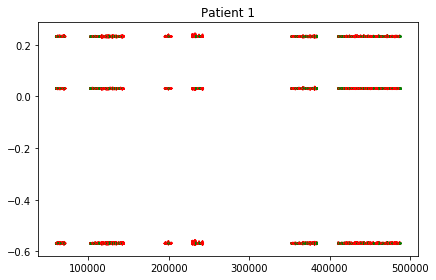

In [6]:
X, Y, bs, can, accel = load_data_from_csv_in_dir("./Final/", plot=True)

In [ ]:
lengths = 0
obs_count, norm_count, count = 0, 0, 0
for i in range(len(accel)):
    obs_count += len(np.where(np.array(Y[i])==1)[0])
    norm_count += len(np.where(np.array(Y[i])==0)[0])
    count += len(accel[i])
    for j in accel[i]:
        lengths += len(j)
print("The duration of recording is: " + str(floor(lengths/32/60/60)) + "h " + str(floor(lengths/32/60%60)) + "min")
print("Total number of breaths:" + str(count))
print("Total number of normal breaths: " + str(norm_count))
print("The percentage of normal breaths: " + str(round((norm_count/count)*100,2)))
print("Total number of obstructed breaths: " + str(obs_count))
print("The percentage of obstructed breaths: " + str(round((obs_count/count)*100,2)))

In [ ]:
ratios = pd.DataFrame()
for j in np.arange(len(X)):
    for i in np.arange(X[j].shape[0]):
        if i > 2:
            ratios = ratios.append(X[j].iloc[i]/X[j].iloc[i-1], ignore_index = True)

ratios_2prev = pd.DataFrame()
for j in np.arange(len(X)):
    for i in np.arange(X[j].shape[0]):
        if i > 2:
            ratios_2prev = ratios_2prev.append(X[j].iloc[i]/X[j].iloc[i-2], ignore_index = True)

#NOT USED
ratios_3prev = pd.DataFrame()
for j in np.arange(len(X)):
    for i in np.arange(X[j].shape[0]):
        if i > 2:
            ratios_3prev = ratios_3prev.append(X[j].iloc[i]/X[j].iloc[i-3], ignore_index = True)


selected = [
# '0.1quant_accel_x_ins', #lower
'0.1quant_accel_z_ins', #lower
'0.25quant_accel_x_ins', #lower
'0.25quant_accel_z_ins', #lower
'0.75quant_accel_z_ins', #lower
# '0.9quant_accel_z_ins', #lower
# 'mean_accel_x_ins', #lower
'mean_accel_z_ins', #lower
# 'median_accel_x_ins', #lower
'median_accel_z_ins', #lower
# 'min_accel_x_ins', #lower
'min_accel_z_ins'] #lower

In [ ]:
X_set = ratios
Y_set, cannula, ac = [], [], []
for i in np.arange(len(Y)):
    for j in np.arange(len(Y[i])):
        if j >= 3:
            Y_set.append(Y[i][j])

for i in np.arange(len(can)):
    for j in np.arange(len(can[i])):
        if j >= 3:
            cannula.append(can[i][j])

for i in np.arange(len(accel)):
    for j in np.arange(len(accel[i])):
        if j >= 3:
            ac.append(accel[i][j])
            
cut = 0.2
cut_low = round((cut-0.2) * X_set.shape[0])
cut_high = round(cut * X_set.shape[0])
X_train, y_train, X_valid, y_valid = X_set.iloc[0:cut_low, :].append(X_set.iloc[cut_high:, :]), Y_set[0:cut_low] + Y_set[cut_high:], X_set.iloc[cut_low:cut_high, :], Y_set[cut_low:cut_high]
can_train, can_valid = cannula[0:cut_low] + cannula[cut_high:], cannula[cut_low:cut_high]
accel_train, accel_valid = ac[0:cut_low] + ac[cut_high:], ac[cut_low:cut_high]
X_train, X_valid = X_train.reset_index(drop=True), X_valid.reset_index(drop=True)

X_set_2prev = ratios_2prev
X_train_2prev, X_valid_2prev = X_set_2prev.iloc[0:cut_low, :].append(X_set_2prev.iloc[cut_high:, :]), X_set_2prev.iloc[cut_low:cut_high, :]
X_set_3prev = ratios_3prev
X_train_3prev, X_valid_3prev = X_set_3prev.iloc[0:cut_low, :].append(X_set_2prev.iloc[cut_high:, :]), X_set_2prev.iloc[cut_low:cut_high, :]
X_train_2prev, X_train_3prev, X_valid_2prev, X_valid_3prev = X_train_2prev.reset_index(drop=True), X_train_3prev.reset_index(drop=True), X_valid_2prev.reset_index(drop=True), X_valid_3prev.reset_index(drop=True)


print (ratios_2prev.shape)
print (ratios.shape)
print("Size of the training set: " + str(len(X_train)))
print("Size of the validation set: " + str(len(X_valid)))

<h1>Baseline</h1>

In [ ]:
median_train = np.median(y_train)
median_valid = np.median(y_valid)
check_train = [median_train] * len(y_train)
check_valid = [median_valid] * len(y_valid)
correct_train = len(np.where(np.array(check_train) == np.array(y_train))[0])
correct_valid = len(np.where(np.array(check_valid) == np.array(y_valid))[0])
print("Training baseline accuracy: " + str(correct_train/len(y_train)*100))
print(str(correct_train) + " out of " + str(len(y_train)))
print("Validation baseline accuracy: " + str(correct_valid/len(y_valid)*100))
print(str(correct_valid) + " out of " + str(len(y_valid)))

<h1>Finding all cyclic obstructions throughout the whole dataset</h1>

In [ ]:
length = 0
j = 0
on = 0
prev_index = 0
period_low, period_high = 3, 4
cyclic_j = []
for i in np.asarray(X_set.index):
    if (Y_set[j] == 1):
        cl = Y_set[j]
        start = 1
        while (cl == 1 and j-start >= 0):
            cl = Y_set[j-start]
            start += 1
        start = j - start + 2
        if (j - start >= period_low):
            on = 1
        else:
            on = 0
    else:
        if (on == 1):
            cl = Y_set[j]
            end = 1
            while cl == 0 and len(Y_set) > j+end:
                cl = Y_set[j+end]
                end += 1
            end = j + end - 1
            if (end -j > period_high):
                end = j+period_high
            if (j - start > period_high):
                start = j-period_high
            if((cannula[j].max()-cannula[j].min())/(cannula[j-1].max()-cannula[j-1].min()) > 1.5 and 
                (cannula[j].max()-cannula[j].min())/(cannula[j-2].max()-cannula[j-2].min()) > 1.5 and
                (cannula[j].max()-cannula[j].min())/(cannula[j-3].max()-cannula[j-3].min()) > 1.5 and
                period_low <= end -j and period_low <= j-start):
                    cyclic_j = cyclic_j + list(range(start, end))
#                     print("Found an interval: " + " " + str(start) + " " + str(end) + " " +str(Y_set[start:end]))
            on = 0
        
    j += 1
print ("Cyclic obstructions:")
print ("Number of cyclic periods: " + str(len(cyclic_j)))
print ("Percentage of cyclic periods: " + str(len(cyclic_j)/X[0].shape[0]*100))

<h1>Plotting accelerometer and cannula values</h1>

In [ ]:
plt.figure(8390, figsize=(9, 3))
plt.subplot(1,2,1)
length = 0
j = 0
for i in range(len(Y_set)):
        if (Y_set[i] == 0):
            plt.plot(np.arange(len(ac[i]))+length, ac[i], '-g')
        if (Y_set[i] == 1):
            plt.plot(np.arange(len(ac[i]))+length, ac[i], '-r')
        length += ac[i].shape[0] + 20
        
plt.subplot(1,2,2)
length = 0
j = 0
for i in range(len(Y_set)):
        if (Y_set[i] == 0):
            plt.plot(np.arange(len(cannula[i]))+length, cannula[i], '-g')
        if (Y_set[i] == 1):
            plt.plot(np.arange(len(cannula[i]))+length, cannula[i], '-r')
        length += cannula[i].shape[0] + 20

<h1>Ratios plots</h1>

In [ ]:
plt.figure(83736, figsize=(12, 95))
norm_index, obstr_index = [], []
p, counter = 0, 0
for j, c in enumerate(Y_set):
    if (j > 0 and c != p and counter >= 3):
        if(c == 0):
            norm_index.append(j)
        else:
            obstr_index.append(j)
    if (p == c and j > 0):
        counter += 1
    else:
        counter = 0
    p = c;
    
i = 1
for col in ratios:
    if col not in ["lengthRatio_accel_x_ins", "lengthRatio_accel_y_ins", "lengthRatio_accel_z_ins"]:
        plt.subplot(44, 5, i)
        plt.scatter(np.ones(len(norm_index)), ratios.loc[norm_index, col].values, c='g', alpha=0.2)
        plt.scatter(np.ones(len(obstr_index))+0.2, ratios.loc[obstr_index, col].values, c='r', alpha=0.2)
        plt.title(col)
        plt.tight_layout()
        i += 1
# plt.savefig("both.png")

<h1>Distribution plots</h1>

In [ ]:
selected = ['0.1quant_accel_z_ins','0.25quant_accel_z_ins', '0.75quant_accel_z_ins',
            'mean_accel_z_ins', 'median_accel_z_ins', '0.1quant_accel_y',
            '0.9quant_accel_y_exp', 'mean_accel_y', 'min_accel_y', 'min_accel_z_ins',
            '0.25quant_accel_y', '0.75quant_accel_y',  '0.25quant_accel_x_ins', 'mean_accel_x_ins', 'median_accel_x_ins']
f, axes = plt.subplots(3, 5, figsize=(15, 10))
count1, count2 = 0, 0
for i in selected:
    x = ratios[i]
    x = round(x, 2)
    sns.distplot(ax = axes[count1,count2], a=x)
    axes[count1,count2].set_xlim(0.94,1.06)
#     plt.xlim(0, 2)
    if(count2==4):
        count2 = 0
        count1 +=1
    else: count2+=1
    plt.tight_layout()
plt.savefig("distplots.png")

<h1>Cyclic periods for the training set</h1>

In [ ]:
length = 0
j = 0
on = 0
prev_index = 0
period_low, period_high = 3, 4
cyclic_j = []
for i in np.asarray(X_train.index):
    if (y_train[j] == 1):
        cl = y_train[j]
        start = 1
        while (cl == 1 and j-start >= 0):
            cl = y_train[j-start]
            start += 1
        start = j - start + 2
        if (j - start >= period_low):
            on = 1
        else:
            on = 0
    else:
        if (on == 1):
            cl = y_train[j]
            end = 1
            while cl == 0 and len(y_train) > j+end:
                cl = y_train[j+end]
                end += 1
            end = j + end - 1
            if (end -j > period_high):
                end = j+period_high
            if (j - start > period_high):
                start = j-period_high
            if((can_train[j].max()-can_train[j].min())/(can_train[j-1].max()-can_train[j-1].min()) > 1.5 and 
                (can_train[j].max()-can_train[j].min())/(can_train[j-2].max()-can_train[j-2].min()) > 1.5 and
                (can_train[j].max()-can_train[j].min())/(can_train[j-3].max()-can_train[j-3].min()) > 1.5 and
                period_low <= end -j and period_low <= j-start):
                    cyclic_j = cyclic_j + list(range(start, end))
#                     print("Found an interval: " + " " + str(start) + " " + str(end) + " " +str(y_train[start:end]))
            on = 0
    j += 1

<h1>Training the ratios model</h1>

In [ ]:
final_predictions = []
thresholds = {}
over = []
for name in selected:
    pred_max = []
    pred = 1
    max_best, min_best, best_correct, best_wrong = 0, 0, 0, X_train.shape[0]
    max_set = np.linspace(1.0, X_train[name].quantile(0.95), num = 100)
    min_set = np.linspace(X_train[name].quantile(0.05), 1.0, num = 100)
    for max_tre in max_set:
        for min_tre in min_set:
            correct, wrong = 0, 0
            predictions = []
            for i, ratio in enumerate(X_train[name]):
                    if (ratio > max_tre):
                        if name in low_obs:   
                            pred = 0
                        else: pred = 1
                    elif(ratio < min_tre): 
                        if name in low_obs: 
                            pred = 1
                        else: pred = 0
                    if (len(predictions) > 2):
#                         if(predictions[-2] == pred and predictions[-1] == pred and pred == 1): #Slowly decreasing obstruction range -> normal
#                             if(X_train_2prev[name].iloc[i] < min_tre and name not in low_obs):
#                                 pred = 0
#                             elif(X_train_2prev[name].iloc[i] > max_tre and name in low_obs):
#                                 pred = 0
                        if(predictions[-2] == pred and predictions[-1] == pred and pred == 0): #Slowly increasing -> obstruction
                            if(X_train_2prev[name].iloc[i] > max_tre and name not in low_obs):
                                pred = 1
                            elif( X_train_2prev[name].iloc[i] < min_tre and name in low_obs):
                                pred = 1
                        elif(predictions[-2] != pred and predictions[-1] != pred and pred == 0): #One accidental
                            if( X_train_2prev[name].iloc[i] > min_tre and name not in low_obs):
                                pred = 1
                            elif(X_train_2prev[name].iloc[i] < max_tre and name in low_obs):
                                pred = 1
                        elif(predictions[-2] != pred and predictions[-1] != pred and pred == 1): #One accidental smaller before
                            if(X_train_2prev[name].iloc[i] < max_tre and name not in low_obs):
                                pred = 0
                            elif(X_train_2prev[name].iloc[i] > min_tre and name in low_obs):
                                pred = 0
                            
                        
                    if(y_train[i] == pred):
                        correct += 1
                    else:
                        wrong += 1
                        if (wrong > best_wrong):
                            break
                    predictions.append(pred)
            if (correct > best_correct):
                best_wrong = wrong
                best_correct = correct
                min_best = min_tre
                max_best = max_tre
                pred_max = predictions
                thresholds[name + "_min"] = min_best
                thresholds[name + "_max"] = max_best
    printmd("**" + name + "**")
    print ("Quantile 0.95: " + str(X_train[name].quantile(0.95)))
    print ("Quantile 0.05: " + str(X_train[name].quantile(0.05)))
    print (str(best_correct) + " out of " + str(X_train.shape[0]))
    print ("Accuracy: " + str(round(best_correct/X_train.shape[0] * 100, 2)) +"%")
    over.append(name)
    print(min_best)
    print(max_best)
    final_predictions.append(pred_max)
print (thresholds)  
print(over)

<h1>Predictions for the training set</h1>

In [ ]:
medians = []
correct = 0
correct_cyclic = 0
indet = 0
for i, pred in enumerate(zip(*final_predictions)):
    med_pred = median(pred)
    if (med_pred == y_train[i]):
        correct += 1
        if i in cyclic_j:
            correct_cyclic += 1
    if (med_pred == 0.5):
        indet += 1
    medians.append(med_pred)
plt.figure(545, figsize=(10, 3))
plt.subplot(1, 2, 1)
length = 0
j = 0
for i in np.asarray(X_train.index):
    if (j in cyclic_j):
        if (medians[j] == 0):
            plt.plot(np.arange(len(can_train[j]))+length, can_train[j], '-g')
        if (medians[j] == 1):
            plt.plot(np.arange(len(can_train[j]))+length, can_train[j], '-r')
        if (y_train[j] == 0):
            plt.plot(np.arange(len(can_train[j]))+length, can_train[j]-0.02, '-g')
        else:
            plt.plot(np.arange(len(can_train[j]))+length, can_train[j]-0.02, '-r')
    length += can_train[j].shape[0] + 20
    j += 1
plt.title("Cannula")
plt.subplot(1, 2, 2)
length = 0
j = 0
for i in np.asarray(X_train.index):
    if (j in cyclic_j):
        if (medians[j] == 0):
            plt.plot(np.arange(len(accel_train[i]))+length, accel_train[i]['accel_y'], '-g')
        if (medians[j] == 1):
            plt.plot(np.arange(len(accel_train[i]))+length, accel_train[i]['accel_y'], '-r')
        if (y_train[j] == 0):
            plt.plot(np.arange(len(accel_train[i]))+length, accel_train[i]['accel_y']-0.4, '-g')
        else:
            plt.plot(np.arange(len(accel_train[i]))+length, accel_train[i]['accel_y']-0.4, '-r')
    length += can_train[i].shape[0] + 20
    j += 1
plt.title("Breathing signal")
print ("Correct: " + str(correct))
print ("Indeterminate: " + str(indet))
print ("Total: " + str(len(y_train)))
print ("Accuracy: " + str(round(correct/len(y_train) * 100, 2)))
print ("Cyclic Accuracy: " + str(round(correct_cyclic/len(cyclic_j) * 100, 2)))

<h1>Cyclic periods for the validation set</h1>

In [ ]:
print ("Cyclic obstructions:")
print(y_valid)
length = 0
j = 0
on = 0
prev_index = 0
period_low, period_high = 3, 5
cyclic_j = []
for i in np.asarray(X_valid.index):
    if (y_valid[j] == 1):
        cl = y_valid[j]
        start = 1
        while (cl == 1 and j-start >= 0):
            cl = y_valid[j-start]
            start += 1
        start = j - start + 2
        if (j - start >= period_low):
            on = 1
        else:
            on = 0
    else:
        if (on == 1):
            cl = y_valid[j]
            end = 1
            while cl == 0 and len(y_valid) > j+end:
                cl = y_valid[j+end]
                end += 1
            end = j + end - 1
            if (end -j > period_high):
                end = j+period_high
            if (j - start > period_high):
                start = j-period_high
            if((can_valid[j].max()-can_valid[j].min())/(can_valid[j-1].max()-can_valid[j-1].min()) > 1.5 and
                (can_valid[j].max()-can_valid[j].min())/(can_valid[j-2].max()-can_valid[j-2].min()) > 1.5 and
                (can_valid[j].max()-can_valid[j].min())/(can_valid[j-3].max()-can_valid[j-3].min()) > 1.5 and
                period_low <= end -j and period_low <= j-start):
                cyclic_j = cyclic_j + list(range(start, end))
#                 print("Found an interval: " + " " + str(start) + " " + str(end) + " " +str(y_valid[start:end]))
            on = 0
        
            
    j += 1

<h1>Predictions for the validation set</h1>

In [ ]:
final_predictions_valid = []
for name in selected:
    pred = 1
    predictions = []
    max_tre = thresholds[name+"_max"]
    min_tre = thresholds[name+"_min"]
    for i, ratio in enumerate(X_valid[name]):
        if (ratio > max_tre):
            if name not in low_obs:   
                pred = 1
            else: pred = 0
        elif(ratio < min_tre): 
            if name not in low_obs: 
                pred = 0
            else: pred = 1
        if (len(predictions) > 3):
#             if(predictions[-2] == pred and predictions[-1] == pred and pred == 1): #Slowly decreasing obstruction range -> normal
#                 if(X_valid_2prev[name].iloc[i] < min_tre and name not in low_obs):
#                     pred = 0
#                 elif(X_valid_2prev[name].iloc[i] > max_tre and name in low_obs):
#                     pred = 0
            if(predictions[-2] == pred and predictions[-1] == pred and pred == 0): #Slowly increasing -> obstruction
                if(X_valid_2prev[name].iloc[i] > max_tre and name not in low_obs):
                    pred = 1
                if(X_valid_2prev[name].iloc[i] < min_tre and name in low_obs):
                    pred = 1
            elif(predictions[-2] != pred and predictions[-1] != pred and pred == 0): #One accidental larger before
                if(X_valid_2prev[name].iloc[i] > min_tre and name not in low_obs):
                    pred = 1
                elif(X_valid_2prev[name].iloc[i] < max_tre and name in low_obs):
                    pred = 1
            elif(predictions[-2] != pred and predictions[-1] != pred and pred == 1): #One accidental smaller before
                if(X_valid_2prev[name].iloc[i] < max_tre and name not in low_obs):
                    pred = 0
                elif(X_valid_2prev[name].iloc[i] > min_tre and name in low_obs):
                    pred = 0
        predictions.append(pred)
    final_predictions_valid.append(predictions)

medians = []
correct = 0
correct_cyclic = 0
indet = 0
y_v = y_valid
for i, pred in enumerate(zip(*final_predictions_valid)):
        med_pred = median(pred)
        if (med_pred == y_valid[i]):
            if(i in cyclic_j):
                correct_cyclic += 1
            correct += 1
        if (med_pred == 0.5):
            indet += 1
        medians.append(med_pred)
plt.figure(5245, figsize=(10, 3))
plt.subplot(1, 2, 1)
length = 0
j = 0
for i in np.asarray(X_valid.index):
#         if(j in cyclic_j):
            if (medians[j] == 0):
        #         plt.plot(np.arange(len(accel_valid[j]))+length, accel_valid[j]-0.2, '-g')
                plt.plot(np.arange(len(can_valid[j]))+length, can_valid[j], '-g')
            if (medians[j] == 1):
        #         plt.plot(np.arange(len(accel_valid[j]))+length, accel_valid[j]-0.2, '-r')
                plt.plot(np.arange(len(can_valid[j]))+length, can_valid[j], '-r')
            if (y_v[j] == 0):
                plt.plot(np.arange(len(can_valid[j]))+length, can_valid[j]-0.04, '-g')
            else:
                plt.plot(np.arange(len(can_valid[j]))+length, can_valid[j]-0.04, '-r')
            length += can_valid[j].shape[0] + 20
            j += 1
plt.title("Cannula")
plt.subplot(1, 2, 2)
length = 0
j = 0
prev_index = 0
for i in np.asarray(X_valid.index):
    if(j in cyclic_j):
        if (medians[j] == 0):
    #         plt.plot(np.arange(len(accel_valid[j]))+length, accel_valid[j]-0.2, '-g')
            plt.plot(np.arange(len(accel_valid[j]))+length, accel_valid[j], '-g')
        if (medians[j] == 1):
    #         plt.plot(np.arange(len(accel_valid[j]))+length, accel_valid[j]-0.2, '-r')
            plt.plot(np.arange(len(accel_valid[j]))+length, accel_valid[j], '-r')
        if (y_v[j] == 0):
            plt.plot(np.arange(len(accel_valid[j]))+length, accel_valid[j]-0.1, '-g')
        else:
            plt.plot(np.arange(len(accel_valid[j]))+length, accel_valid[j]-0.1, '-r')
    length += accel_valid[j].shape[0] + 20
    j += 1
plt.title("Breathing signal")
# plt.xlim([23700, 25000])

print(cyclic_j)
    
print ("Correct: " + str(correct))
print ("Indeterminate: " + str(indet))
print ("Total: " + str(len(y_valid)))
print ("Accuracy: " + str(round(correct/len(y_valid) * 100, 2)))
print ("Accuracy of cyclic: " + str(round(correct_cyclic/len(cyclic_j) * 100, 2)))

<h1>Baseline k-folds</h1>

In [ ]:
tr_acc, val_acc = [], []
for cut in [0.2, 0.4, 0.6, 0.8, 1.0]:
    cut_low = round((cut-0.2) * X_set.shape[0])
    cut_high = round(cut * X_set.shape[0])
    y_train, y_valid = Y_set[0:cut_low] + Y_set[cut_high:], Y_set[cut_low:cut_high]
    median_train = np.median(y_train)
    median_valid = np.median(y_valid)
    check_train = [median_train] * len(y_train)
    check_valid = [median_valid] * len(y_valid)
    correct_train = len(np.where(np.array(check_train) == np.array(y_train))[0])
    correct_valid = len(np.where(np.array(check_valid) == np.array(y_valid))[0])
    tr_acc += [correct_train/len(y_train)*100]
    val_acc += [correct_valid/len(y_valid)*100]
print("K-fold baseline training accuracy: " + str(np.mean(tr_acc)))
print("K-fold baseline validation accuracy: " + str(np.mean(val_acc)))

<h1>K-folds between subsets of a set or just a regular k-folds</h1>

In [ ]:
selected = ['0.1quant_accel_x_ins', #lower
# '0.1quant_accel_y', #lower
'0.1quant_accel_z_ins', #lower
'0.25quant_accel_x_ins', #lower
# '0.25quant_accel_y', #lower
'0.25quant_accel_z_ins', #lower
# '0.75quant_accel_y', #lower
'0.75quant_accel_z_ins', #lower
# '0.9quant_accel_y_exp', #lower
'0.9quant_accel_z_ins', #lower
# 'max_accel_y', #lower
# 'mean_accel_y', #lower
'mean_accel_x_ins', #lower
'mean_accel_z_ins', #lower
'median_accel_x_ins', #lower
# 'median_accel_y', #lower
'median_accel_z_ins', #lower
# 'min-mean_accel_z', #higher
'min_accel_x_ins', #lower
# 'min_accel_y', #lower
'min_accel_z_ins'] #lower
# 'std_accel_x_ins'] #higher]

selected = ['0.1quant_accel_x_ins', #lower
'0.1quant_accel_y', #lower
'0.1quant_accel_z_ins', #lower
'0.25quant_accel_x_ins', #lower
# '0.25quant_accel_y', #lower
'0.25quant_accel_z_ins', #lower
# '0.75quant_accel_y', #lower
'0.75quant_accel_z_ins', #lower
'0.9quant_accel_y_exp', #lower
'0.9quant_accel_z_ins', #lower
# 'max_accel_y', #lower
'mean_accel_y', #lower
'mean_accel_x_ins', #lower
'mean_accel_z_ins', #lower
# 'median_accel_x_ins', #lower
# 'median_accel_y', #lower
'median_accel_z_ins', #lower
# 'min-mean_accel_z', #higher
# 'min_accel_x_ins', #lower
# 'min_accel_y', #lower
'min_accel_z_ins'] #lower
# 'std_accel_x_ins'] #higher]

selected = ['0.1quant_accel_z_ins','0.25quant_accel_z_ins', '0.75quant_accel_z_ins',
            'mean_accel_z_ins', 'median_accel_z_ins', '0.1quant_accel_y',
            '0.9quant_accel_y_exp', 'mean_accel_y', 'min_accel_y', 'min_accel_z_ins',
            '0.25quant_accel_y', '0.75quant_accel_y',  '0.25quant_accel_x_ins', 'mean_accel_x_ins', 'median_accel_x_ins']

selected = ['0.1quant_accel_z_ins', '0.25quant_accel_z_ins', '0.75quant_accel_z_ins', 'mean_accel_z_ins', 'median_accel_z_ins', '0.1quant_accel_y', '0.9quant_accel_y_exp', 'mean_accel_y', 'min_accel_y', 'min_accel_z_ins', '0.25quant_accel_y', '0.75quant_accel_y', '0.25quant_accel_x_ins', 'mean_accel_x_ins', 'median_accel_x_ins']

subs = [selected]
best_ft, best_val, best_tr, best_val_cyc, best_tr_cyc = [], 0, 0, 0, 0
period_low, period_high = 3, 4
for selected in subs:
    tr_acc, tr_acc_cyc = [], []
    val_acc, val_acc_cyc = [], []
    printmd("**K-fold started**")
    print("Features: ", end=" ")
    print(selected)
    for cut in [0.2, 0.4, 0.6, 0.8, 1.0]:
        cut_low = round((cut-0.2) * X_set.shape[0])
        cut_high = round(cut * X_set.shape[0])
        X_train, y_train, X_valid, y_valid = X_set.iloc[0:cut_low, :].append(X_set.iloc[cut_high:, :]), Y_set[0:cut_low] + Y_set[cut_high:], X_set.iloc[cut_low:cut_high, :], Y_set[cut_low:cut_high]
        can_train, can_valid = cannula[0:cut_low] + cannula[cut_high:], cannula[cut_low:cut_high]
        X_train, X_valid = X_train.reset_index(drop=True), X_valid.reset_index(drop=True)

        X_set_2prev = ratios_2prev
        X_train_2prev, X_valid_2prev = X_set_2prev.iloc[0:cut_low, :].append(X_set_2prev.iloc[cut_high:, :]), X_set_2prev.iloc[cut_low:cut_high, :]
        X_set_3prev = ratios_3prev
        X_train_3prev, X_valid_3prev = X_set_3prev.iloc[0:cut_low, :].append(X_set_2prev.iloc[cut_high:, :]), X_set_2prev.iloc[cut_low:cut_high, :]
        X_train_2prev, X_train_3prev, X_valid_2prev, X_valid_3prev = X_train_2prev.reset_index(drop=True), X_train_3prev.reset_index(drop=True), X_valid_2prev.reset_index(drop=True), X_valid_3prev.reset_index(drop=True)
        final_predictions = []
        thresholds = {}
        over = []
        #New only cyclic
        length = 0
        j = 0
        on = 0
        prev_index = 0
        cyclic_j = []
        for i in np.asarray(X_train.index):
            if (y_train[j] == 1):
                cl = y_train[j]
                start = 1
                while (cl == 1 and j-start >= 0):
                    cl = y_train[j-start]
                    start += 1
                start = j - start + 2
                if (j - start >= period_low):
                    on = 1
                else:
                    on = 0
            else:
                if (on == 1):
                    cl = y_train[j]
                    end = 1
                    while cl == 0 and len(y_train) > j+end:
                        cl = y_train[j+end]
                        end += 1
                    end = j + end - 1
                    if (end -j > period_high):
                        end = j+period_high
                    if (j - start > period_high):
                        start = j-period_high
                    if((can_train[j].max()-can_train[j].min())/(can_train[j-1].max()-can_train[j-1].min()) > 1.5 and 
                       (can_train[j].max()-can_train[j].min())/(can_train[j-2].max()-can_train[j-2].min()) > 1.5 and
                       (can_train[j].max()-can_train[j].min())/(can_train[j-3].max()-can_train[j-3].min()) > 1.5 and
                       period_low <= end -j and period_low <= j-start):
                        cyclic_j = cyclic_j + list(range(start, end))
                    on = 0
            j += 1
        for name in selected:
            pred_max = []
            pred = 1
            max_best, min_best, best_correct, best_wrong, best_all_correct = 0, 0, 0, X_train.shape[0], 0
            max_set = np.linspace(1.0, X_train[name].quantile(0.95), num = 100)
            min_set = np.linspace(X_train[name].quantile(0.05), 1.0, num = 100)

            for max_tre in max_set:
                for min_tre in min_set:
                    correct, wrong, all_correct = 0, 0, 0
                    predictions = []
                    for i, ratio in enumerate(X_train[name]):
                            if (ratio > max_tre):
                                if name in low_obs:   
                                    pred = 0
                                else: pred = 1
                            elif(ratio < min_tre): 
                                if name in low_obs: 
                                    pred = 1
                                else: pred = 0
                            if (len(predictions) > 2):
#                                 if(predictions[-2] == pred and predictions[-1] == pred and pred == 1): #Slowly decreasing obstruction range -> normal
#                                     if(X_train_2prev[name].iloc[i] < min_tre and name not in low_obs):
#                                         pred = 0
#                                     elif(X_train_2prev[name].iloc[i] > max_tre and name in low_obs):
#                                         pred = 0
                                if(predictions[-2] == pred and predictions[-1] == pred and pred == 0): #Slowly increasing -> obstruction
                                    if(X_train_2prev[name].iloc[i] > max_tre and name not in low_obs):
                                        pred = 1
                                    elif(X_train_2prev[name].iloc[i] < min_tre and name in low_obs):
                                        pred = 1
                                elif(predictions[-2] != pred and predictions[-1] != pred and pred == 0): #One accidental
                                    if(X_train_2prev[name].iloc[i] > min_tre and name not in low_obs):
                                        pred = 1
                                    elif(X_train_2prev[name].iloc[i] < max_tre and name in low_obs):
                                        pred = 1
                                elif(predictions[-2] != pred and predictions[-1] != pred and pred == 1): #One accidental smaller before
                                    if(X_train_2prev[name].iloc[i] < max_tre and name not in low_obs):
                                        pred = 0
                                    elif(X_train_2prev[name].iloc[i] > min_tre and name in low_obs):
                                        pred = 0


                            if(y_train[i] == pred and i in cyclic_j):
                                correct += 1 
                            if(y_train[i] == pred):
                                all_correct += 1 
                            if(y_train[i] != pred and i in cyclic_j):
                                wrong += 1
                                if (wrong > best_wrong):
                                    break
                            predictions.append(pred)
                    if (correct > best_correct or (correct==best_correct and all_correct > best_all_correct)):
                        best_correct = correct
                        best_wrong = wrong
                        best_all_correct = all_correct
                        min_best = min_tre
                        max_best = max_tre
                        pred_max = predictions
                        thresholds[name + "_min"] = min_best
                        thresholds[name + "_max"] = max_best
            final_predictions.append(pred_max)
        
        medians = []
        correct = 0
        correct_cyclic = 0
        indet = 0
        for i, pred in enumerate(zip(*final_predictions)):
            med_pred = median(pred)
            if (med_pred == y_train[i]):
                correct += 1
                if i in cyclic_j:
                    correct_cyclic += 1
            if (med_pred == 0.5):
                indet += 1
            medians.append(med_pred)
        tr_acc += [round(correct/len(y_train) * 100, 4)]
        tr_acc_cyc += [round(correct_cyclic/len(cyclic_j) * 100, 4)]
        final_predictions_valid = []
        for name in selected:
            pred = 1
            predictions = []
            max_tre = thresholds[name+"_max"]
            min_tre = thresholds[name+"_min"]
            for i, ratio in enumerate(X_valid[name]):
                if (ratio > max_tre):
                    if name not in low_obs:   
                        pred = 1
                    else: pred = 0
                elif(ratio < min_tre): 
                    if name not in low_obs: 
                        pred = 0
                    else: pred = 1
                if (len(predictions) > 2):
#                     if(predictions[-2] == pred and predictions[-1] == pred and pred == 1): #Slowly decreasing obstruction range -> normal
#                         if(X_valid_2prev[name].iloc[i] < min_tre and name not in low_obs):
#                             pred = 0
#                         elif(X_valid_2prev[name].iloc[i] > max_tre and name in low_obs):
#                             pred = 0
                    if(predictions[-2] == pred and predictions[-1] == pred and pred == 0): #Slowly increasing -> obstruction
                        if(X_valid_2prev[name].iloc[i] > max_tre and name not in low_obs):
                            pred = 1
                        if(X_valid_2prev[name].iloc[i] < min_tre and name in low_obs):
                            pred = 1
                    elif(predictions[-2] != pred and predictions[-1] != pred and pred == 0): #One accidental larger before
                        if(X_valid_2prev[name].iloc[i] > min_tre and name not in low_obs):
                            pred = 1
                        elif(X_valid_2prev[name].iloc[i] < max_tre and name in low_obs):
                            pred = 1
                    elif(predictions[-2] != pred and predictions[-1] != pred and pred == 1): #One accidental smaller before
                        if(X_valid_2prev[name].iloc[i] < max_tre and name not in low_obs):
                            pred = 0
                        elif(X_valid_2prev[name].iloc[i] > min_tre and name in low_obs):
                            pred = 0
                predictions.append(pred)
            final_predictions_valid.append(predictions)
        length = 0
        j = 0
        on = 0
        prev_index = 0
        cyclic_j = []
        for i in np.asarray(X_valid.index):
            if (y_valid[j] == 1):
                cl = y_valid[j]
                start = 1
                while (cl == 1 and j-start >= 0):
                    cl = y_valid[j-start]
                    start += 1
                start = j - start + 2
                if (j - start >= period_low):
                    on = 1
                else:
                    on = 0
            else:
                if (on == 1):
                    cl = y_valid[j]
                    end = 1
                    while cl == 0 and len(y_valid) > j+end:
                        cl = y_valid[j+end]
                        end += 1
                    end = j + end - 1
                    if (end -j > period_high):
                        end = j+period_high
                    if (j - start > period_high):
                        start = j-period_high
                    if((can_valid[j].max()-can_valid[j].min())/(can_valid[j-1].max()-can_valid[j-1].min()) > 1.5 and
                       (can_valid[j].max()-can_valid[j].min())/(can_valid[j-2].max()-can_valid[j-2].min()) > 1.5 and 
                       (can_valid[j].max()-can_valid[j].min())/(can_valid[j-3].max()-can_valid[j-3].min()) > 1.5 and
                       period_low <= end -j and period_low <= j-start):
                        cyclic_j = cyclic_j + list(range(start, end))
                    on = 0
            j += 1
        medians = []
        correct = 0
        correct_cyclic = 0
        indet = 0
        for i, pred in enumerate(zip(*final_predictions_valid)):
                med_pred = median(pred)
                if (med_pred == y_valid[i]):
                    if(i in cyclic_j):
                        correct_cyclic += 1
                    correct += 1
                if (med_pred == 0.5):
                    indet += 1
                medians.append(med_pred)
        printmd("**VALIDATION**")
        print ("Correct: " + str(correct))
        print ("Indeterminate: " + str(indet))
        print ("Total: " + str(len(y_valid)))
        print ("Accuracy: " + str(round(correct/len(y_valid) * 100, 2)))
        print ("Accuracy of cyclic: " + str(round(correct_cyclic/len(cyclic_j) * 100, 2)))
        print("Number of cyclic breaths: " + str(len(cyclic_j)))
        val_acc += [round(correct/len(y_valid) * 100, 4)]
        val_acc_cyc += [round(correct_cyclic/len(cyclic_j) * 100, 4)]
    printmd("**K-fold done**")
    print("K-fold training accuracy: " + str(np.mean(tr_acc)))
    print("K-fold training cyclic accuracy: " + str(np.mean(tr_acc_cyc)))
    print("K-fold validation accuracy: " + str(np.mean(val_acc)))
    print("K-fold validation cyclic accuracy: " + str(np.mean(val_acc_cyc)))
    if(np.mean(val_acc) > best_val):
        best_val = np.mean(val_acc)
        best_tr = np.mean(tr_acc)
        best_val_cyc = np.mean(val_acc_cyc)
        best_tr_cyc = np.mean(tr_acc_cyc)
        best_ft = selected

In [ ]:
from itertools import chain, combinations
 
selected =[
'0.25quant_accel_y',
'0.75quant_accel_y',
'0.9quant',
'0.9quant_accel_y',
'max-mean',
'max_accel_y',
'mean_accel_y',
'median_accel_y',
'range',
'std',
'std_accel_z']
def all_subsets(ss):
    return chain(*map(lambda x: combinations(ss, x), range(0, len(ss)+1)))
subs = []
for subset in all_subsets(selected):
    subset = list(subset)
    if (len(subset) > 9):
        subs.append(subset)
print (len(subs))

<h1>Testing each feature on accuracy</h1>

In [ ]:
# 0: 'lengthRatio_ins', 'length_ins', 'max-mean', 'max-mean_exp', 'max-mean_ins', 'range', 'range_exp', 'range_ins',  'std', 'std_exp', 'std_ins'
# 1: 'mean_cross_exp', mean_cross_ins', 'min-mean', 'min-mean_exp', 'min-mean_ins', 'peaks', 'peaks_exp', 'peaks_ins', 
# selected = ['lengthRatio_ins', 'length_ins', 'length_exp', 'range', 'range_exp', 'range_ins', 'std', 'std_exp', 'std_ins']
selected =[
'0.25quant_accel_y',
'0.75quant_accel_y',
'0.9quant',
'0.9quant_accel_y',
'max-mean',
'max_accel_y',
'mean_accel_y',
'median_accel_y',
'range',
'std',
'std_accel_z']

selected = ['0.1quant_accel_x_ins', #lower
'0.1quant_accel_y', #lower
'0.1quant_accel_z_ins', #lower
'0.25quant_accel_x_ins', #lower
'0.25quant_accel_y', #lower
'0.25quant_accel_z_ins', #lower
'0.75quant_accel_y', #lower
'0.75quant_accel_z_ins', #lower
'0.9quant_accel_y_exp', #lower
'0.9quant_accel_z_ins', #lower
'max_accel_y', #lower
'mean_accel_y', #lower
'mean_accel_x_ins', #lower
'mean_accel_z_ins', #lower
'median_accel_x_ins', #lower
'median_accel_y', #lower
'median_accel_z_ins', #lower
'min-mean_accel_z', #higher
'min_accel_x_ins', #lower
'min_accel_y', #lower
'min_accel_z_ins', #lower
'std_accel_x_ins'] #higher]

subs = [selected]
best_ft, best_val, best_tr, best_val_cyc, best_tr_cyc = [], 0, 0, 0, 0
period_low, period_high = 3, 4
feature_acc_all = []
for name in selected:
    tr_acc, tr_acc_cyc = [], []
    val_acc, val_acc_cyc = [], []
    
    final_predictions = []
    thresholds = {}
    over = []
    feature_acc = []
    for cut in [0.2, 0.4, 0.6, 0.8, 1.0]:
        pred_max = []
        pred = 1
        cut_low = round((cut-0.2) * X_set.shape[0])
        cut_high = round(cut * X_set.shape[0])
        X_train, y_train, X_valid, y_valid = X_set.iloc[0:cut_low, :].append(X_set.iloc[cut_high:, :]), Y_set[0:cut_low] + Y_set[cut_high:], X_set.iloc[cut_low:cut_high, :], Y_set[cut_low:cut_high]
        can_train, can_valid = cannula[0:cut_low] + cannula[cut_high:], cannula[cut_low:cut_high]
        X_train, X_valid = X_train.reset_index(drop=True), X_valid.reset_index(drop=True)

        X_set_2prev = ratios_2prev
        X_train_2prev, X_valid_2prev = X_set_2prev.iloc[0:cut_low, :].append(X_set_2prev.iloc[cut_high:, :]), X_set_2prev.iloc[cut_low:cut_high, :]
        X_set_3prev = ratios_3prev
        X_train_3prev, X_valid_3prev = X_set_3prev.iloc[0:cut_low, :].append(X_set_2prev.iloc[cut_high:, :]), X_set_2prev.iloc[cut_low:cut_high, :]
        X_train_2prev, X_train_3prev, X_valid_2prev, X_valid_3prev = X_train_2prev.reset_index(drop=True), X_train_3prev.reset_index(drop=True), X_valid_2prev.reset_index(drop=True), X_valid_3prev.reset_index(drop=True)

        max_best, min_best, best_correct, best_wrong = 0, 0, 0, X_train.shape[0]
        max_set = np.linspace(1.0, X_train[name].quantile(0.95), num = 100)
        min_set = np.linspace(X_train[name].quantile(0.05), 1.0, num = 100)
            
        for max_tre in max_set:
            for min_tre in min_set:
                correct, wrong = 0, 0
                predictions = []
                for i, ratio in enumerate(X_train[name]):
                        if (ratio > max_tre):
                            if name in low_obs:  
                                pred = 0
                            else: pred = 1
                        elif(ratio < min_tre): 
                            if name in low_obs: 
                                pred = 1
                            else: pred = 0
                        if (len(predictions) > 2):
#                                 if(predictions[-2] == pred and predictions[-1] == pred and pred == 1): #Slowly decreasing obstruction range -> normal
#                                     if(X_train_2prev[name].iloc[i] < min_tre and name not in low_obs):
#                                         pred = 0
#                                     elif(X_train_2prev[name].iloc[i] > max_tre and name in low_obs):
#                                         pred = 0
                            if(predictions[-2] == pred and predictions[-1] == pred and pred == 0): #Slowly increasing -> obstruction
                                if(X_train_2prev[name].iloc[i] > max_tre and name not in low_obs):
                                    pred = 1
                                elif(X_train_2prev[name].iloc[i] < min_tre and name in low_obs):
                                    pred = 1
                            elif(predictions[-2] != pred and predictions[-1] != pred and pred == 0): #One accidental
                                if(X_train_2prev[name].iloc[i] > min_tre and name not in low_obs):
                                    pred = 1
                                elif(X_train_2prev[name].iloc[i] < max_tre and name in low_obs):
                                    pred = 1
                            elif(predictions[-2] != pred and predictions[-1] != pred and pred == 1): #One accidental smaller before
                                if(X_train_2prev[name].iloc[i] < max_tre and name not in low_obs):
                                    pred = 0
                                elif(X_train_2prev[name].iloc[i] > min_tre and name in low_obs):
                                    pred = 0


                        if(y_train[i] == pred):
                            correct += 1 
                        else:
                            wrong += 1
                            if (wrong > best_wrong):
                                break
                        predictions.append(pred)
                if (correct > best_correct):
                    best_correct = correct
                    best_wrong = wrong
                    pred_max = predictions
        printmd("**" + name + "**")
        print ("Quantile 0.95: " + str(X_train[name].quantile(0.95)))
        print ("Quantile 0.05: " + str(X_train[name].quantile(0.05)))
        print (str(best_correct) + " out of " + str(X_train.shape[0]))
        print ("Accuracy: " + str(round(best_correct/X_train.shape[0] * 100, 2)) +"%")
        feature_acc += [round(best_correct/X_train.shape[0] * 100, 2)]
    feature_acc_all.append(feature_acc)

<h1>Selecting features based on cyclic periods accuracy</h1>

In [ ]:
selected = ['0.1quant_accel_x_ins', #lower
'0.1quant_accel_y', #lower
'0.1quant_accel_z_ins', #lower
'0.25quant_accel_x_ins', #lower
'0.25quant_accel_y', #lower
'0.25quant_accel_z_ins', #lower
'0.75quant_accel_y', #lower
'0.75quant_accel_z_ins', #lower
'0.9quant_accel_y_exp', #lower
'0.9quant_accel_z_ins', #lower
'max_accel_y', #lower
'mean_accel_y', #lower
'mean_accel_x_ins', #lower
'mean_accel_z_ins', #lower
'median_accel_x_ins', #lower
'median_accel_y', #lower
'median_accel_z_ins', #lower
'min-mean_accel_z', #higher
'min_accel_x_ins', #lower
'min_accel_y', #lower
'min_accel_z_ins', #lower
'std_accel_x_ins'] #higher]

best_ft, best_val, best_tr, best_val_cyc, best_tr_cyc = [], 0, 0, 0, 0
period_low, period_high = 3, 4
for name in selected:
    
    pred = 1

    X_set_2prev = ratios_2prev
    X_set_3prev = ratios_3prev
    max_best, min_best, best_correct = 0, 0, 0
    max_set = np.linspace(1.0, X_set[name].quantile(0.95), num = 100)
    min_set = np.linspace(X_set[name].quantile(0.05), 1.0, num = 100)

    
     #New only cyclic
    length = 0
    j = 0
    on = 0
    prev_index = 0
    cyclic_j = []
    for i in np.asarray(X_set.index):
        if (Y_set[j] == 1):
            cl = Y_set[j]
            start = 1
            while (cl == 1 and j-start >= 0):
                cl = Y_set[j-start]
                start += 1
            start = j - start + 2
            if (j - start >= period_low):
                on = 1
            else:
                on = 0
        else:
            if (on == 1):
                cl = Y_set[j]
                end = 1
                while cl == 0 and len(Y_set) > j+end:
                    cl = Y_set[j+end]
                    end += 1
                end = j + end - 1
                if (end -j > period_high):
                    end = j+period_high
                if (j - start > period_high):
                    start = j-period_high
                if((cannula[j].max()-cannula[j].min())/(cannula[j-1].max()-cannula[j-1].min()) > 1.5 and 
                   (cannula[j].max()-cannula[j].min())/(cannula[j-2].max()-cannula[j-2].min()) > 1.5 and
                   (cannula[j].max()-cannula[j].min())/(cannula[j-3].max()-cannula[j-3].min()) > 1.5 and
                   period_low <= end -j and period_low <= j-start):
                    cyclic_j = cyclic_j + list(range(start, end))
                on = 0
        j += 1
    for max_tre in max_set:
        for min_tre in min_set:
            correct, wrong = 0, 0
            predictions = []
            for i, ratio in enumerate(X_set[name]):
                    if (ratio > max_tre):
                        if name in low_obs:  
                            pred = 0
                        else: pred = 1
                    elif(ratio < min_tre): 
                        if name in low_obs: 
                            pred = 1
                        else: pred = 0
                    if (len(predictions) > 2):
#                                 if(predictions[-2] == pred and predictions[-1] == pred and pred == 1): #Slowly decreasing obstruction range -> normal
#                                     if(X_set_2prev[name].iloc[i] < min_tre and name not in low_obs):
#                                         pred = 0
#                                     elif(X_set_2prev[name].iloc[i] > max_tre and name in low_obs):
#                                         pred = 0
                        if(predictions[-2] == pred and predictions[-1] == pred and pred == 0): #Slowly increasing -> obstruction
                            if(X_set_2prev[name].iloc[i] > max_tre and name not in low_obs):
                                pred = 1
                            elif(X_set_2prev[name].iloc[i] < min_tre and name in low_obs):
                                pred = 1
                        elif(predictions[-2] != pred and predictions[-1] != pred and pred == 0): #One accidental
                            if(X_set_2prev[name].iloc[i] > min_tre and name not in low_obs):
                                pred = 1
                            elif(X_set_2prev[name].iloc[i] < max_tre and name in low_obs):
                                pred = 1
                        elif(predictions[-2] != pred and predictions[-1] != pred and pred == 1): #One accidental smaller before
                            if(X_set_2prev[name].iloc[i] < max_tre and name not in low_obs):
                                pred = 0
                            elif(X_set_2prev[name].iloc[i] > min_tre and name in low_obs):
                                pred = 0


                    if(Y_set[i] == pred and i in cyclic_j):
                        correct += 1 
                    predictions.append(pred)
            if (correct > best_correct):
                best_correct = correct
                best_wrong = wrong
                pred_max = predictions
    printmd("**" + name + "**")
    print (str(best_correct) + " out of " + str(len(cyclic_j)))
    print ("Accuracy: " + str(round(best_correct/len(cyclic_j) * 100, 2)) +"%")
   

In [ ]:
print(feature_acc_all)
for i, feat in enumerate(feature_acc_all):
    print("Feature: " + selected[i])
    print("Accuracy: " + str(round(np.mean(feat), 2)))